# a questo punto ho il dataset pronto per effettuarci un'analisi e feature engineering oltre che la data visualizzation

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas.api.types import CategoricalDtype
from scipy.stats import chi2_contingency
import seaborn as sns



df = pd.read_csv('cleaned_data.csv')
df.head()

,_STATE,GENHLTH,PHYSHLTH,MENTHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,BPHIGH4,BLOODCHO,...,SEATBELT,FLUSHOT6,PNEUVAC3,HIVTST6,_RACE,_AGE_G,_BMI5CAT,_SMOKER3,_PACAT1,NUMADULT_2
0,1.0,5.0,15.0,18.0,1.0,1.0,0.0,1.0,1.0,1,...,1.0,1.0,1.0,1.0,1.0,5,4.0,3.0,4.0,3.0
1,1.0,3.0,0.0,0.0,0.0,1.0,1.0,4.0,NaN,1,...,3.0,0.0,0.0,0.0,1.0,4,3.0,1.0,2.0,1.0
2,1.0,5.0,30.0,30.0,1.0,1.0,1.0,1.0,1.0,1,...,1.0,1.0,1.0,NaN,1.0,5,3.0,4.0,4.0,3.0
3,1.0,5.0,20.0,0.0,1.0,1.0,0.0,1.0,NaN,1,...,1.0,0.0,1.0,1.0,1.0,5,2.0,4.0,4.0,2.0
4,1.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1,...,1.0,1.0,1.0,0.0,1.0,6,3.0,4.0,1.0,1.0


In [198]:
binary_cols = ['HLTHPLN1','MEDCOST','BLOODCHO','TOLDHI2','CVDINFR4',
               'CVDCRHD4','CVDSTRK3','ASTHMA3','CHCSCNCR','CHCOCNCR',
               'CHCCOPD1','HAVARTH3','ADDEPEV2','CHCKIDNY','VETERAN3',
               'INTERNET','QLACTLM2','USEEQUIP','BLIND','DECIDE',
               'DIFFWALK','DIFFDRES','DIFFALON','SMOKE100','EXERANY2','FLUSHOT6',
               'PNEUVAC3', 'HIVTST6', 'PERSDOC2', 'BPHIGH4'] 
nominal_cols = [
    '_STATE','SEX','MARITAL','EMPLOY1','_RACE', '_BMI5CAT'
]

numeric_cols = [
    'PHYSHLTH','MENTHLTH','CHILDREN','NUMADULT_2',
    'ALCDAY5', 'FRUITJU1','FRUIT1', 'FVBEANS','FVGREEN',
    'FVORANG','VEGETAB1',  'STRENGTH'
]


def to_binary(series, yes_value=1, no_value=2):
    """
    Trasforma una Serie pandas con codifica 1=yes, 2=no in 0/1.
    - yes_value  → 1
    - no_value   → 0
    - tutti gli altri valori → np.nan
    """
    return series.map({yes_value: 1, no_value: 0}).astype('Int64')

for col in binary_cols:
    if col in df.columns:
        df[f'{col}'] = to_binary(df[col])
    else:
        print(f"Colonna `{col}` non trovata nel DataFrame. Operazione saltata.")


ordinal_asc = {
    'GENHLTH':       [1,2,3,4,5],       # 1=Excellent … 5=Poor
    'CHECKUP1':      [1,2,3,4,5,6,7,8], # 
    'CHOLCHK':       [1,2,3,4],         
    '_AGE_G':        [1,2,3,4,5,6],     # 1=18–24 … 6=65+
    '_PACAT1':       [1,2,3,4],         # 1=High active … 4=Inactive
    'SEATBELT':      [1,2,3,4,5]        # 1=Always … 5=Never (invertito)
}

# e quali ordinali hanno codifica "1 = worst, ↑ = better" (e.g. lower code = peggiore)
ordinal_desc = {
    'EDUCA':         [6,5,4,3,2,1],     # 1=None … 6=Post-grad (invertito)
    'INCOME2':       [8,7,6,5,4,3,2,1],     # 1=Less than $10K … 6=$75K or more
    '_SMOKER3':      [4,3,2,1] ,         # 1=Current every day … 4=Never
    'USENOW3':       [3,2,1]          # 1=Every day … 3=Not at all (invertito)
}

# 2) Cast nominali a 'category' (manteniamo i codici numerici)
for col in nominal_cols:
    df[col] = df[col].astype('category')

# 3) Cast ordinali a 'category' con ordered=True
for col, cats in ordinal_asc.items():
    cat_type = CategoricalDtype(categories=cats, ordered=True)
    df[col] = df[col].astype(cat_type)

for col, cats in ordinal_desc.items():
    cat_type = CategoricalDtype(categories=cats, ordered=True)
    df[col] = df[col].astype(cat_type)


df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# 5) Controllo finale
print("Dtypes finali:")
print(df[nominal_cols + list(ordinal_asc) + list(ordinal_desc) + numeric_cols].dtypes)


Dtypes finali:
_STATE        category
SEX           category
MARITAL       category
EMPLOY1       category
_RACE         category
_BMI5CAT      category
GENHLTH       category
CHECKUP1      category
CHOLCHK       category
_AGE_G        category
_PACAT1       category
SEATBELT      category
EDUCA         category
INCOME2       category
_SMOKER3      category
USENOW3       category
PHYSHLTH       float64
MENTHLTH       float64
CHILDREN       float64
NUMADULT_2     float64
ALCDAY5        float64
FRUITJU1       float64
FRUIT1         float64
FVBEANS        float64
FVGREEN        float64
FVORANG        float64
VEGETAB1       float64
STRENGTH       float64
dtype: object


In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321457 entries, 0 to 321456
Data columns (total 59 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   _STATE      321457 non-null  category
 1   GENHLTH     320707 non-null  category
 2   PHYSHLTH    315181 non-null  float64 
 3   MENTHLTH    316891 non-null  float64 
 4   HLTHPLN1    304968 non-null  Int64   
 5   PERSDOC2    287776 non-null  Int64   
 6   MEDCOST     27015 non-null   Int64   
 7   CHECKUP1    318370 non-null  category
 8   BPHIGH4     148310 non-null  Int64   
 9   BLOODCHO    321457 non-null  Int64   
 10  CHOLCHK     317268 non-null  category
 11  TOLDHI2     137499 non-null  Int64   
 12  CVDINFR4    21101 non-null   Int64   
 13  CVDCRHD4    21460 non-null   Int64   
 14  CVDSTRK3    14649 non-null   Int64   
 15  ASTHMA3     43177 non-null   Int64   
 16  CHCSCNCR    35369 non-null   Int64   
 17  CHCOCNCR    35539 non-null   Int64   
 18  CHCCOPD1    28072 non-nu

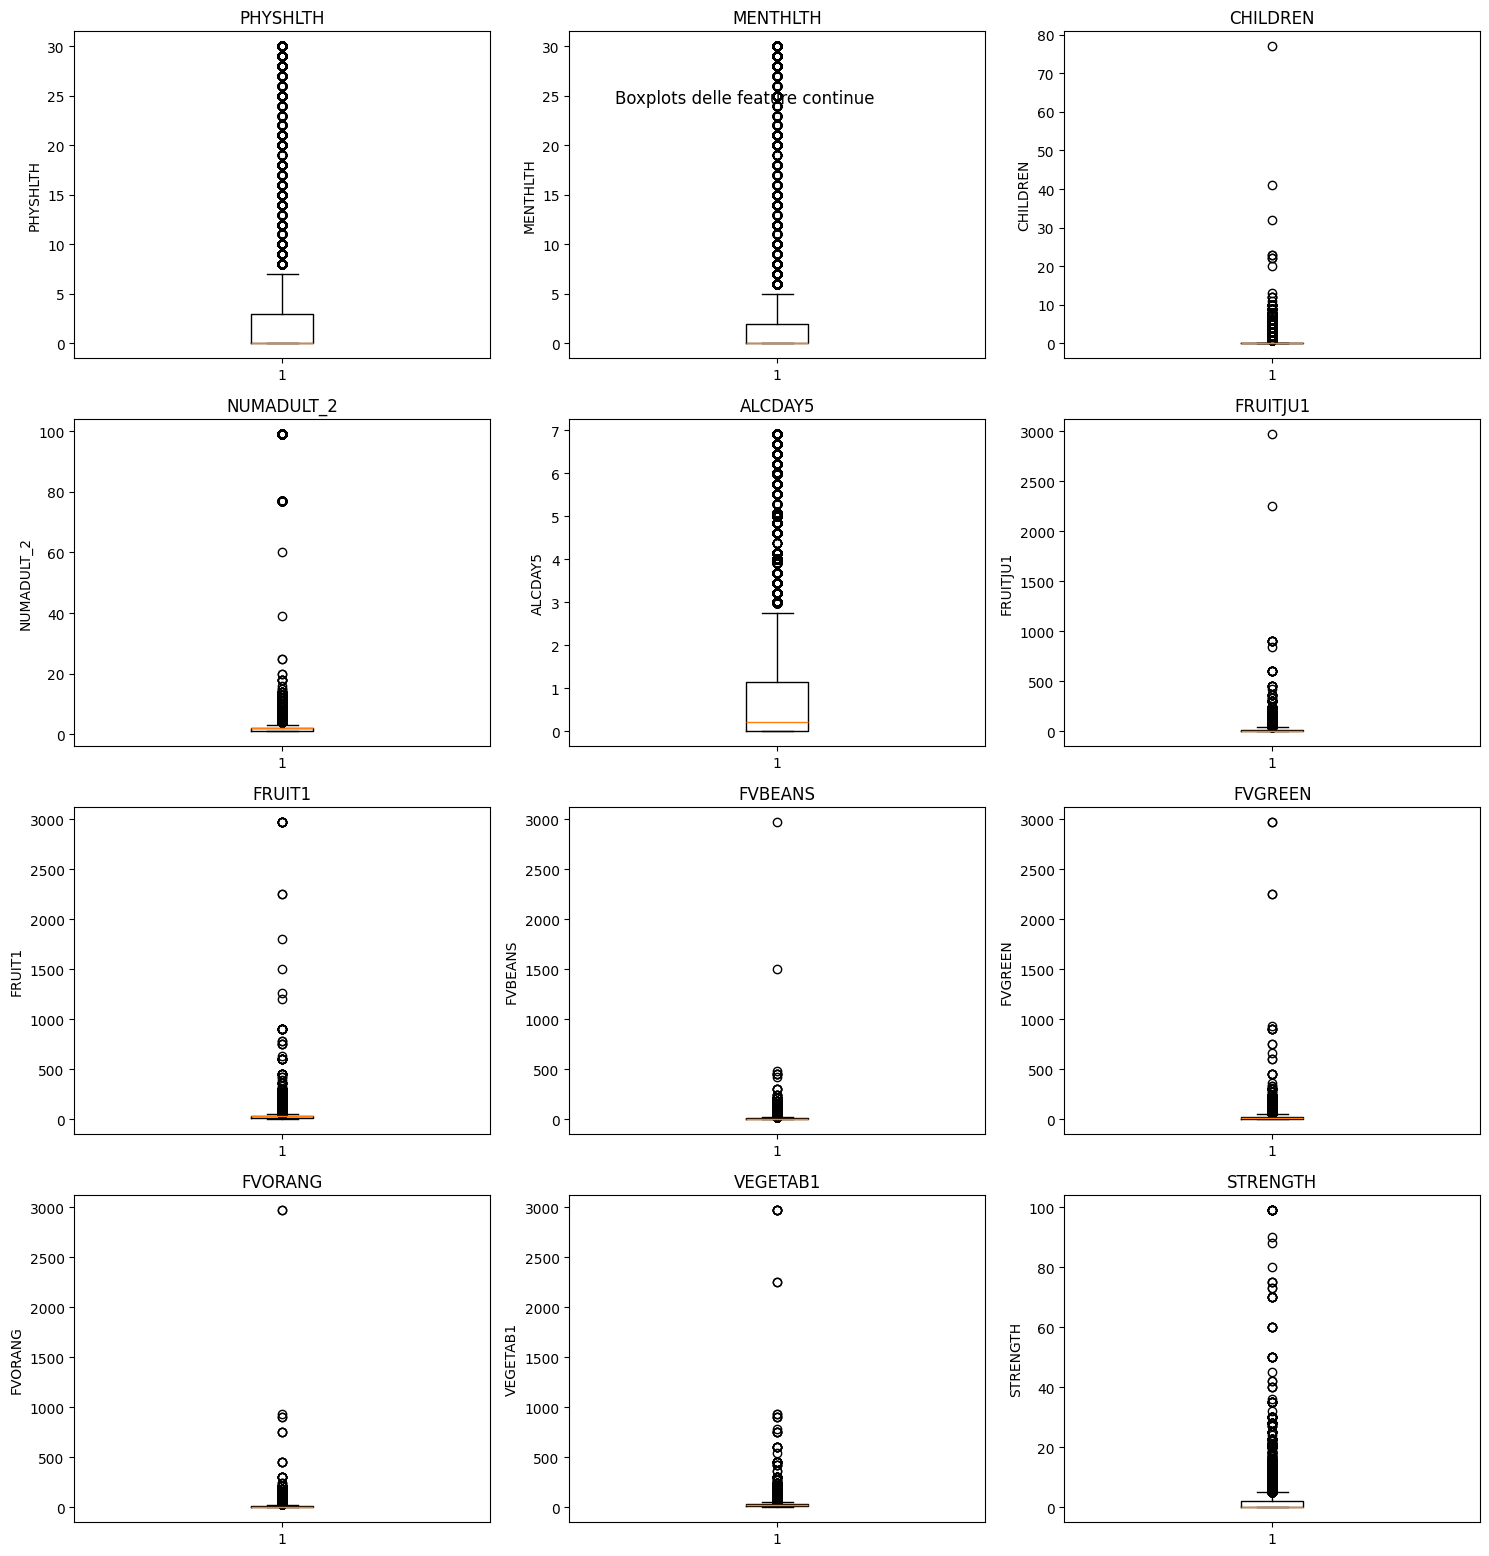

In [200]:

# Target variable
target = 'DIABETE3'

# 1) Boxplot in griglia per le feature continue
n = len(numeric_cols)
ncols = 3
nrows = int(np.ceil(n/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))
for ax, col in zip(axes.flatten(), numeric_cols):
    ax.boxplot(df[col].dropna())
    ax.set_title(col)
    ax.set_ylabel(col)

# Disattiva i pannelli inutilizzati
for ax in axes.flatten()[n:]:
    ax.axis('off')
fig.suptitle('Boxplots delle feature continue', y=0.92)
plt.tight_layout()
plt.show()


Alcuni valori sembrano poco plausibili come ad esempio il 77 di children, probabilmente dovuto ad un errore. Applico ad alcune feature un logaritmo per poterle vedere meglio.

In [201]:
df['CHILDREN'] = df['CHILDREN'].where(df['CHILDREN'] <= 10, np.nan)
# 2) Winsorizzazione al 1° e 99° percentile per variabili skewed
skew_vars = ['PHYSHLTH','MENTHLTH','NUMADULT_2',
    'ALCDAY5', 'FRUITJU1','FRUIT1', 'FVBEANS','FVGREEN',
    'FVORANG','VEGETAB1',  'STRENGTH']
for var in skew_vars:
    lower = df[var].quantile(0.01)
    upper = df[var].quantile(0.99)
    df[f'{var}'] = df[var].clip(lower=lower, upper=upper)

# 3) Trasformazioni: log(x+1) e sqrt(x) su variabili winsorizzate
for var in skew_vars:
    df[f'{var}'] = np.log1p(df[f'{var}'])
    df[f'{var}'] = np.sqrt(df[f'{var}'])


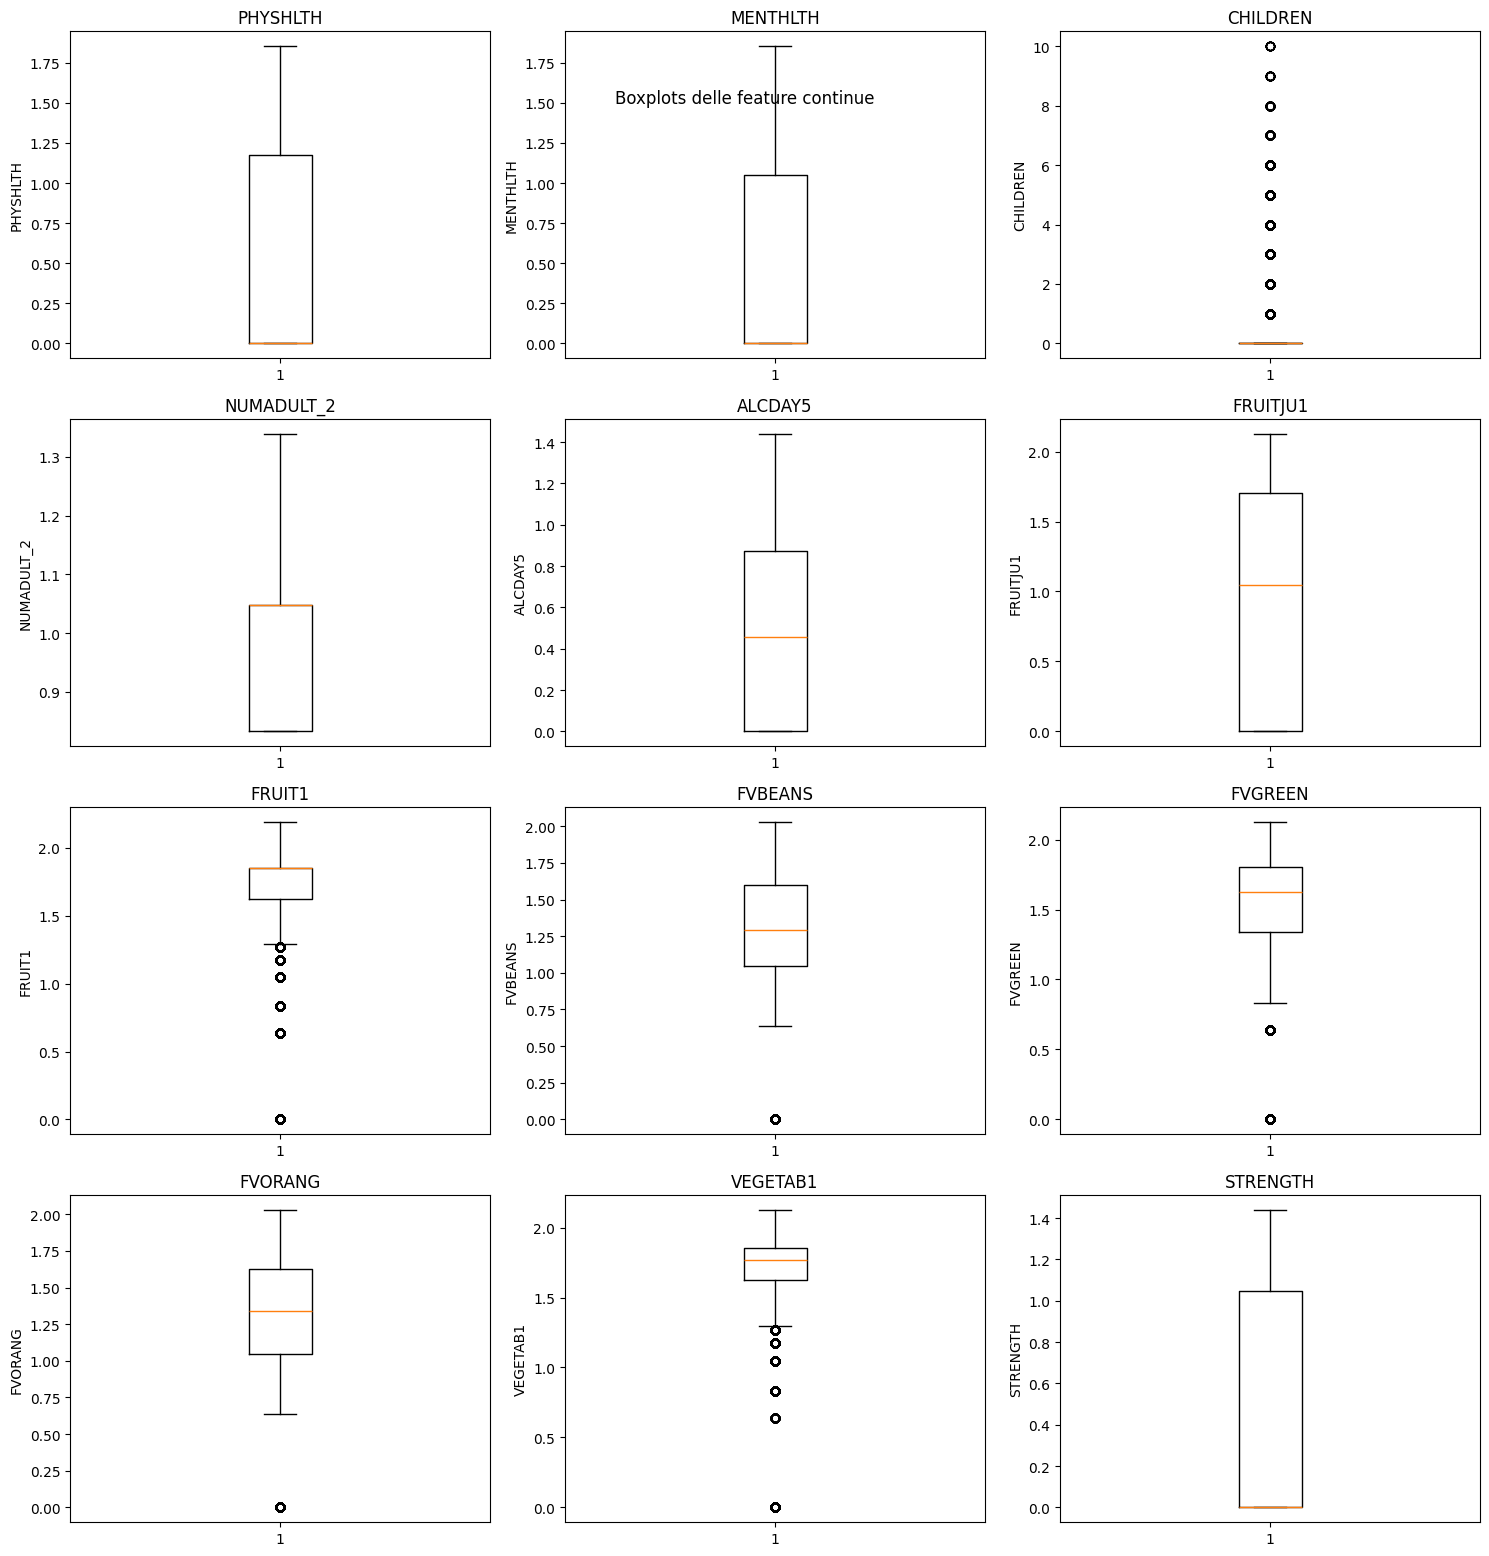

In [202]:

# 1) Boxplot in griglia per le feature continue
n = len(numeric_cols)
ncols = 3
nrows = int(np.ceil(n/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))
for ax, col in zip(axes.flatten(), numeric_cols):
    ax.boxplot(df[col].dropna())
    ax.set_title(col)
    ax.set_ylabel(col)

# Disattiva i pannelli inutilizzati
for ax in axes.flatten()[n:]:
    ax.axis('off')
fig.suptitle('Boxplots delle feature continue', y=0.92)
plt.tight_layout()
plt.show()


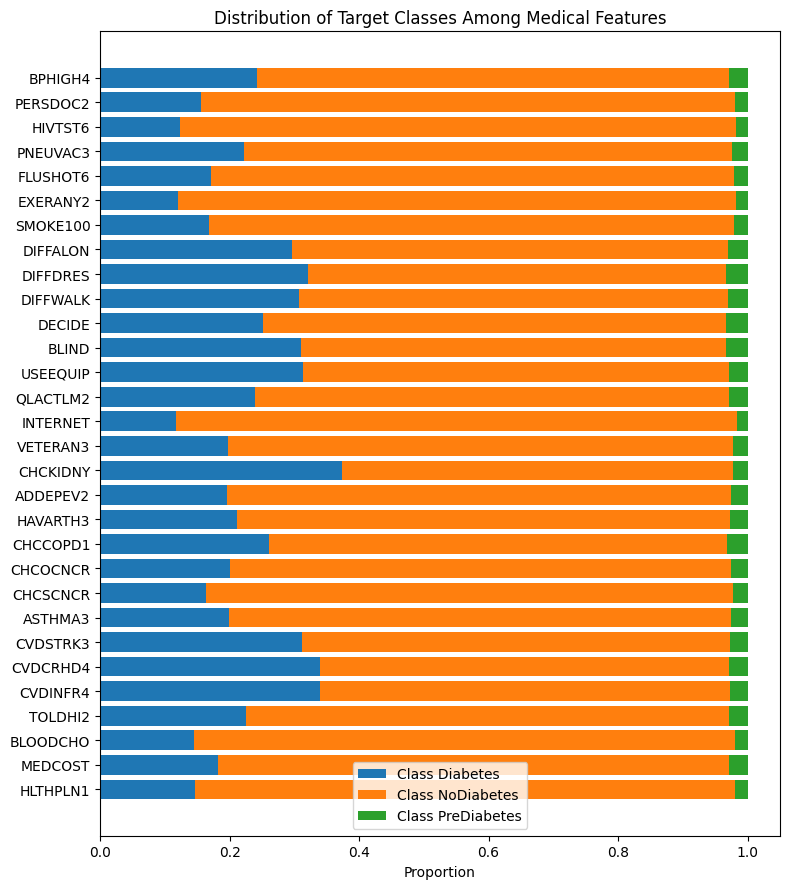

In [203]:
classes = sorted(df[target].unique())
prop_df = pd.DataFrame(index=binary_cols, columns=classes, dtype=float)

for col in binary_cols:
    subset = df[df[col] == 1]
    p = subset[target].value_counts(normalize=True)
    for cls in classes:
        prop_df.loc[col, cls] = p.get(cls, 0)

# Plot horizontal stacked bar chart with three (or more) classes
fig, ax = plt.subplots(figsize=(8, len(binary_cols) * 0.3))
y = np.arange(len(binary_cols))
left = np.zeros(len(binary_cols))

for cls in classes:
    ax.barh(y, prop_df[cls], left=left, label=f'Class {cls}')
    left += prop_df[cls]

ax.set_yticks(y)
ax.set_yticklabels(binary_cols)
ax.set_xlabel('Proportion')
ax.set_title('Distribution of Target Classes Among Medical Features')
ax.legend(loc='best')

plt.tight_layout()
plt.show()

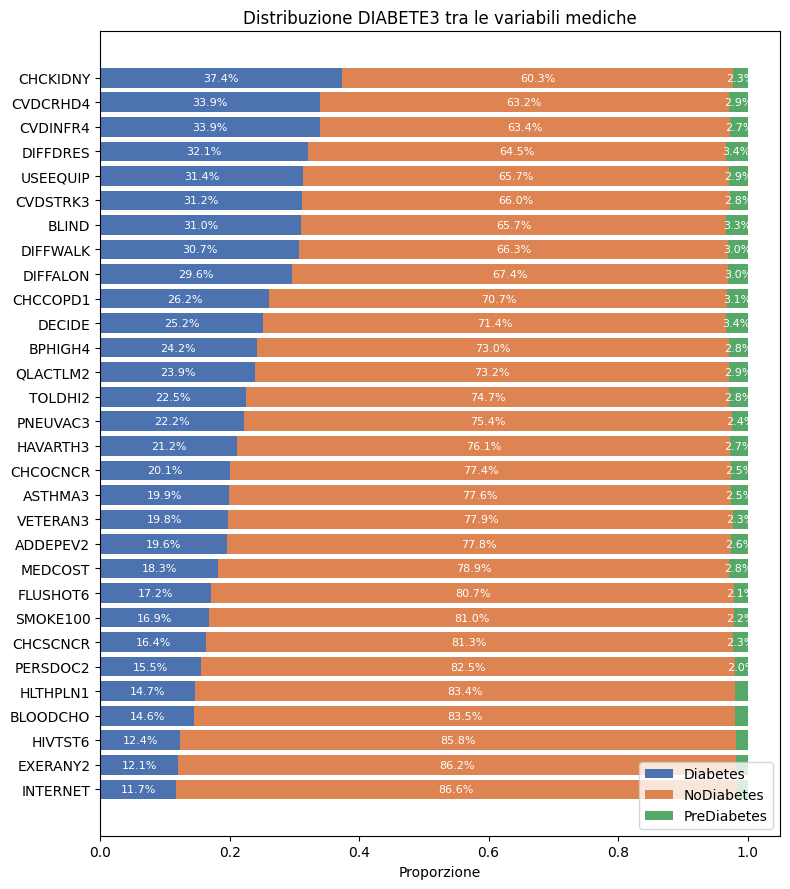

In [204]:

# 2) Ordina per la colonna 'Diabetes'
prop_df = prop_df.sort_values(by='Diabetes', ascending=False)

# 3) Prepara colori e labels
colors = ['#4C72B0', '#DD8452', '#55A868']   # blu, arancio, verde
labels = prop_df.columns.tolist()           # ['NoDiabetes','Diabetes','PreDiabetes']

fig, ax = plt.subplots(figsize=(8, len(prop_df)*0.3))
y = np.arange(len(prop_df))
left = np.zeros(len(prop_df))

# 4) Costruisci il barh impilato iterando sulle colonne reali
for color, cls in zip(colors, labels):
    vals = prop_df[cls].values
    ax.barh(y, vals, left=left, color=color, label=cls)
    # Annotazioni percentuali
    for idx, v in enumerate(vals):
        if v > 0.02:  # solo se >2%
            ax.text(left[idx] + v/2, idx,
                    f"{v*100:.1f}%",
                    va='center', ha='center',
                    color='white', fontsize=8)
    left += vals

# 5) Formattazione finale
ax.set_yticks(y)
ax.set_yticklabels(prop_df.index)
ax.invert_yaxis()  # feature col più diabetici in alto
ax.set_xlabel('Proporzione')
ax.set_title('Distribuzione DIABETE3 tra le variabili mediche')
ax.legend(loc='lower right', frameon=True)
plt.tight_layout()
plt.show()


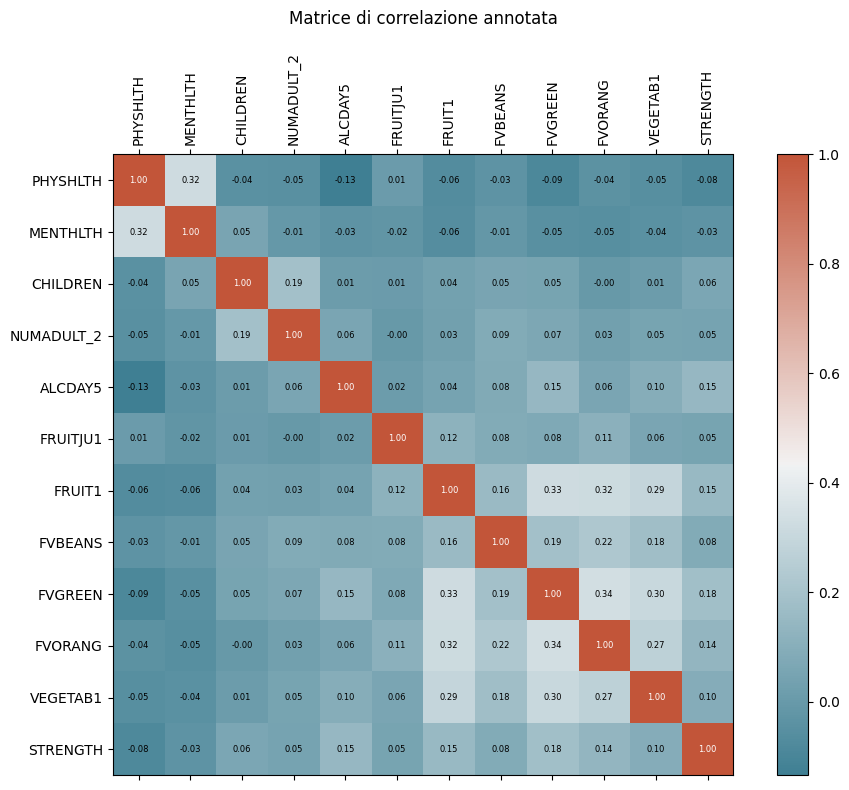

In [205]:
# 4) Heatmap annotata della correlazione
corr = df[numeric_cols].corr()
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# 3) Disegna la heatmap
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr, cmap=cmap)
fig.colorbar(cax)

# 4) Tick e label
ticks = np.arange(len(numeric_cols))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(numeric_cols, rotation=90)
ax.set_yticklabels(numeric_cols)

# 5) Annotazioni
for i in ticks:
    for j in ticks:
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}",
                ha='center', va='center', fontsize=6,
                color='white' if abs(corr.iloc[i, j]) > 0.5 else 'black')

plt.title('Matrice di correlazione annotata', pad=20)
plt.tight_layout()
plt.show()

Guardando questa matrice di correlazione salta all'occhio come le variabili dedicate al consumo di cibo sano siano correlate tra loro e potremmo raggrupparle

In [206]:
#controllo quanta varianza spiega la prima componente principale della pca effettuata sul gruppo di variabili correlate riguardanti l'alimentazione sana
"""
nutri_cols = ['FRUIT1', 'FVBEANS','FVGREEN',
    'FVORANG','VEGETAB1']
df[nutri_cols] = df[nutri_cols].fillna(df[nutri_cols].mean())
Xs = StandardScaler().fit_transform(df[nutri_cols])
pca = PCA(n_components=1).fit(Xs)
print("Varianza spiegata PC1:", pca.explained_variance_ratio_[0])

"""

#spiega solo il 40% della varianza, quindi non è una buona rappresentazione del dataset

'\nnutri_cols = [\'FRUIT1\', \'FVBEANS\',\'FVGREEN\',\n    \'FVORANG\',\'VEGETAB1\']\ndf[nutri_cols] = df[nutri_cols].fillna(df[nutri_cols].mean())\nXs = StandardScaler().fit_transform(df[nutri_cols])\npca = PCA(n_components=1).fit(Xs)\nprint("Varianza spiegata PC1:", pca.explained_variance_ratio_[0])\n\n'

In [207]:
# https://pubmed.ncbi.nlm.nih.gov/16321593/
#https://www.cdc.gov/pcd/issues/2014/13_0390.htm?utm_source
# i paper che spiegano il perchè dei pesi
nutri_cols = ['FRUIT1', 'FVBEANS','FVGREEN',
    'FVORANG','VEGETAB1']

weights = {'FRUIT1':1, 'FVBEANS':1.2, 'FVGREEN':1.5, 'FVORANG':0.5, 'VEGETAB1':1.5}
df['NutritionScore'] = sum(df[c] * w for c,w in weights.items())

df.drop(columns=nutri_cols, inplace=True)


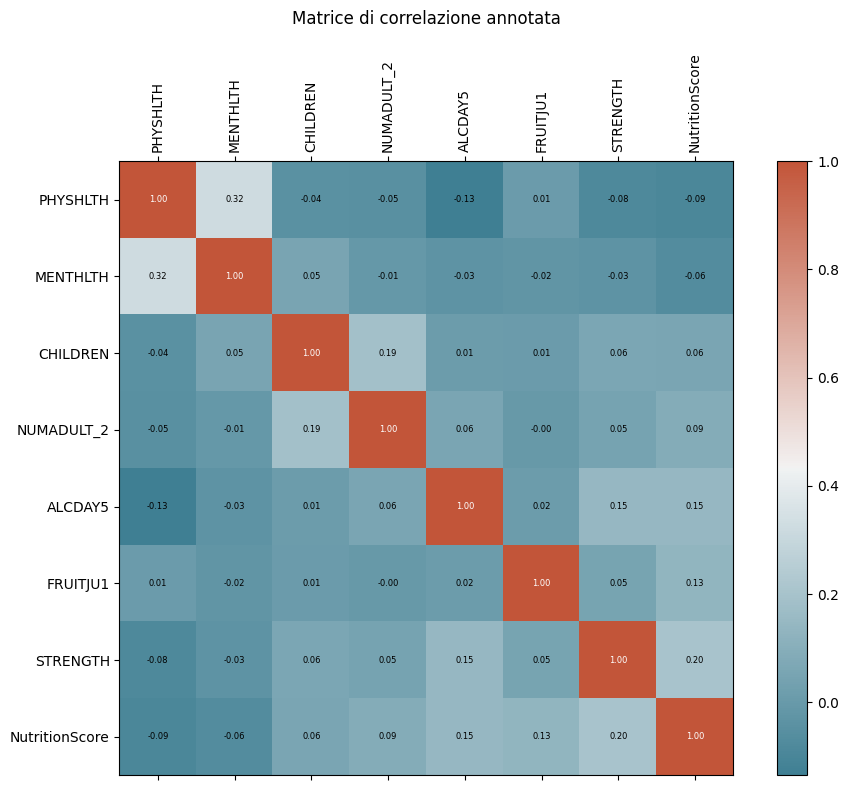

In [208]:
numeric_cols = [
    'PHYSHLTH','MENTHLTH','CHILDREN','NUMADULT_2',
    'ALCDAY5', 'FRUITJU1', 'STRENGTH', 'NutritionScore'
]


# 4) Heatmap annotata della correlazione
corr = df[numeric_cols].corr()
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# 3) Disegna la heatmap
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr, cmap=cmap)
fig.colorbar(cax)

# 4) Tick e label
ticks = np.arange(len(numeric_cols))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(numeric_cols, rotation=90)
ax.set_yticklabels(numeric_cols)

# 5) Annotazioni
for i in ticks:
    for j in ticks:
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}",
                ha='center', va='center', fontsize=6,
                color='white' if abs(corr.iloc[i, j]) > 0.5 else 'black')

plt.title('Matrice di correlazione annotata', pad=20)
plt.tight_layout()
plt.show()

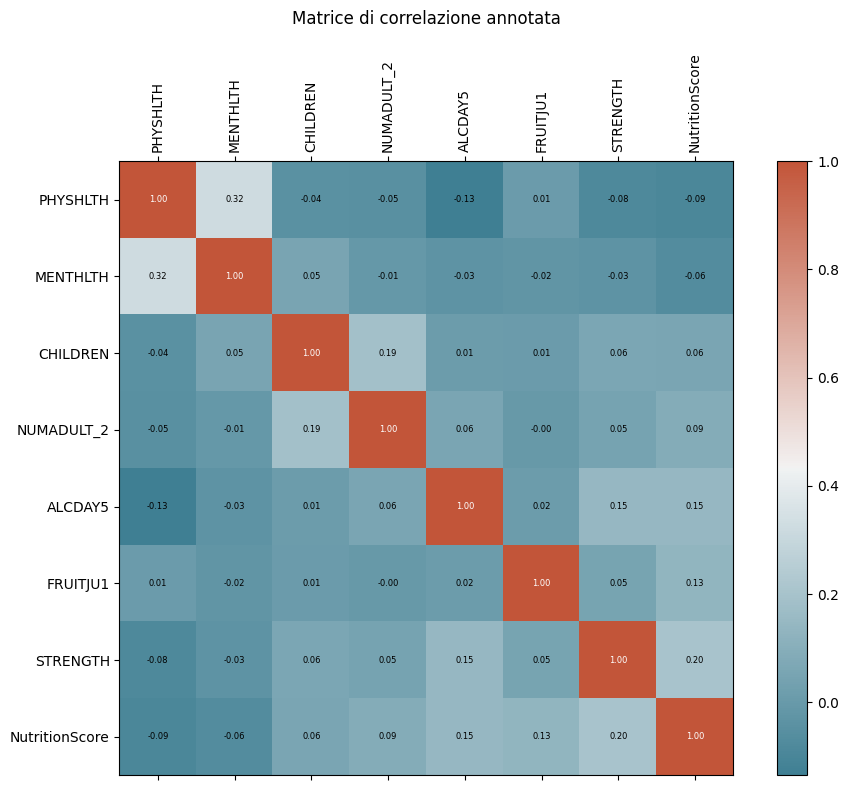

In [209]:
# 4) Heatmap annotata della correlazione
corr = df[numeric_cols].corr()
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# 3) Disegna la heatmap
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr, cmap=cmap)
fig.colorbar(cax)

# 4) Tick e label
ticks = np.arange(len(numeric_cols))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(numeric_cols, rotation=90)
ax.set_yticklabels(numeric_cols)

# 5) Annotazioni
for i in ticks:
    for j in ticks:
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}",
                ha='center', va='center', fontsize=6,
                color='white' if abs(corr.iloc[i, j]) > 0.5 else 'black')

plt.title('Matrice di correlazione annotata', pad=20)
plt.tight_layout()
plt.show()

/var/folders/6v/1zb17jyj7kb910z5z0pnvx5c0000gn/T/ipykernel_27783/2190210974.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_c.groupby(['_STATE', 'DIABETE3']).size().unstack(fill_value=0)


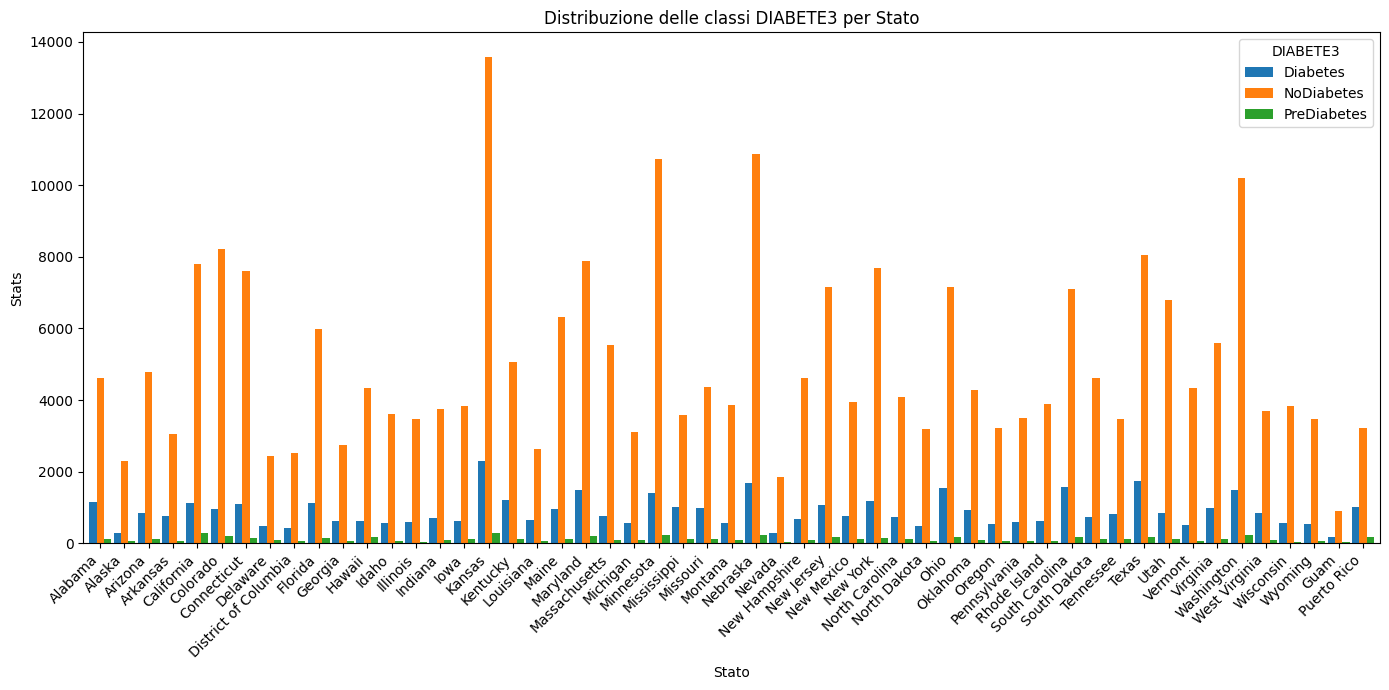

In [210]:
import pandas as pd
import matplotlib.pyplot as plt

df_c = df.copy()
state_map = {
    1: "Alabama", 2: "Alaska", 4: "Arizona", 5: "Arkansas", 6: "California",
    8: "Colorado", 9: "Connecticut", 10: "Delaware", 11: "District of Columbia",
    12: "Florida", 13: "Georgia", 15: "Hawaii", 16: "Idaho", 17: "Illinois",
    18: "Indiana", 19: "Iowa", 20: "Kansas", 21: "Kentucky", 22: "Louisiana",
    23: "Maine", 24: "Maryland", 25: "Massachusetts", 26: "Michigan",
    27: "Minnesota", 28: "Mississippi", 29: "Missouri", 30: "Montana",
    31: "Nebraska", 32: "Nevada", 33: "New Hampshire", 34: "New Jersey",
    35: "New Mexico", 36: "New York", 37: "North Carolina", 38: "North Dakota",
    39: "Ohio", 40: "Oklahoma", 41: "Oregon", 42: "Pennsylvania",
    44: "Rhode Island", 45: "South Carolina", 46: "South Dakota",
    47: "Tennessee", 48: "Texas", 49: "Utah", 50: "Vermont", 51: "Virginia",
    53: "Washington", 54: "West Virginia", 55: "Wisconsin", 56: "Wyoming",
    66: "Guam", 72: "Puerto Rico"
}
df_c['_STATE'] = df['_STATE'].map(state_map)
# Raggruppa e conta
counts = df_c.groupby(['_STATE', 'DIABETE3']).size().unstack(fill_value=0)

# Crea il bar chart raggruppato
ax = counts.plot(kind='bar', figsize=(14, 7), width=0.9, stacked=False)
ax.set_xlabel('Stato')
ax.set_ylabel('Stats')
ax.set_title('Distribuzione delle classi DIABETE3 per Stato')
ax.legend(title='DIABETE3', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


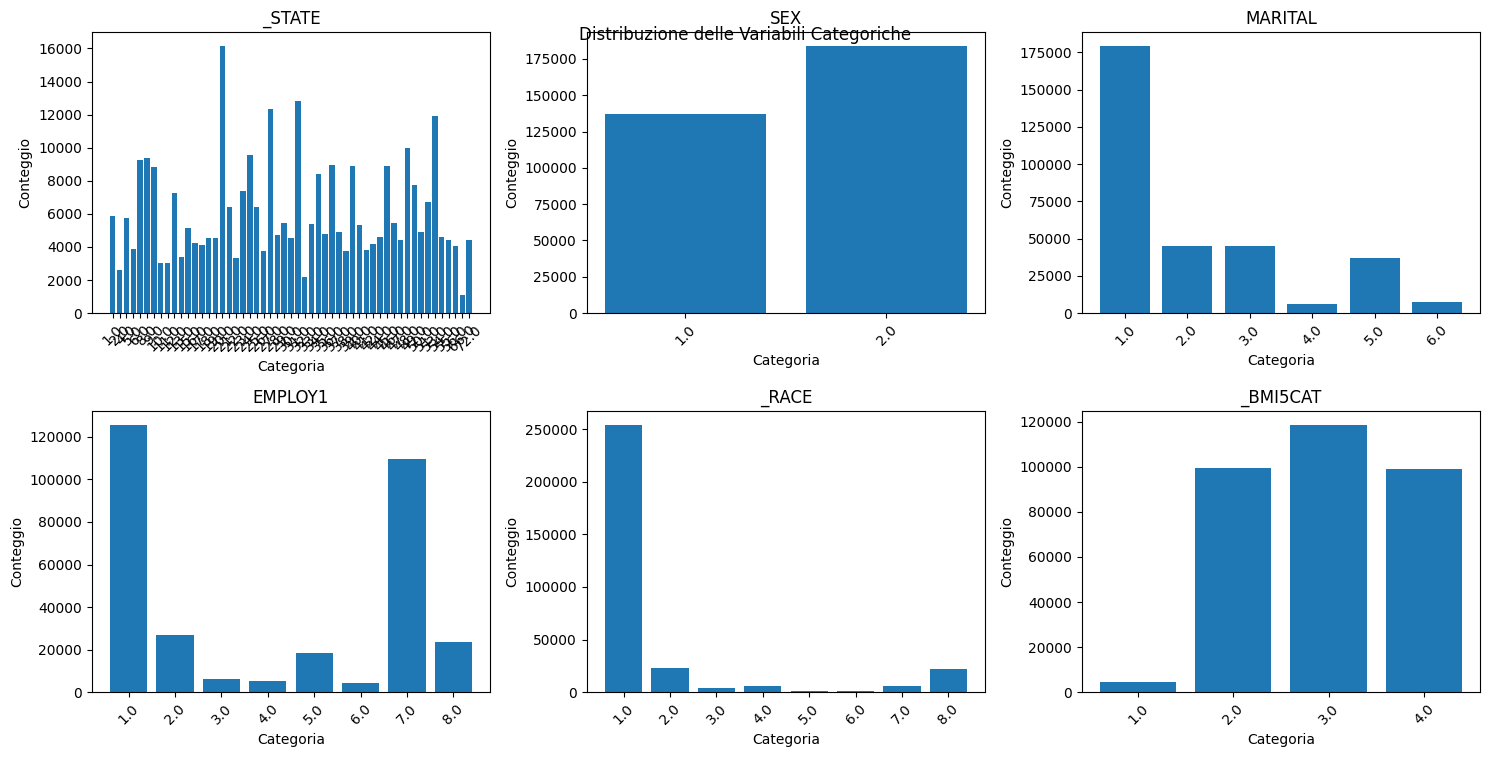

In [211]:


n = len(nominal_cols)
cols = 3
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
axes = axes.flatten()

for ax, col in zip(axes, nominal_cols):
    counts = df[col].value_counts().sort_index()
    ax.bar(counts.index.astype(str), counts.values)
    ax.set_title(col)
    ax.set_xlabel('Categoria')
    ax.set_ylabel('Conteggio')
    ax.tick_params(axis='x', rotation=45)

# Disattiva i subplot rimasti vuoti
for ax in axes[n:]:
    ax.axis('off')

fig.suptitle('Distribuzione delle Variabili Categoriche', y=0.92)
plt.tight_layout()
plt.show()


in employ la categoria 3 e 4 si può raggruppare insieme essendo entrambe 'out of work' ma per differenti periodi di tempo.

In [212]:

df['EMPLOY1'] = df['EMPLOY1'].replace({4: 3, 6:3})
df['_RACE'] = df['_RACE'].replace({4: 3, 5: 3, 6: 3, 7: 3})
df['MARITAL'] = df['MARITAL'].replace({6: 4})


/var/folders/6v/1zb17jyj7kb910z5z0pnvx5c0000gn/T/ipykernel_27783/705019754.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['EMPLOY1'] = df['EMPLOY1'].replace({4: 3, 6:3})
/var/folders/6v/1zb17jyj7kb910z5z0pnvx5c0000gn/T/ipykernel_27783/705019754.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['_RACE'] = df['_RACE'].replace({4: 3, 5: 3, 6: 3, 7: 3})
/var/folders/6v/1zb17jyj7kb910z5z0pnvx5c0000gn/T/ipykernel_27783/705019754.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future versi

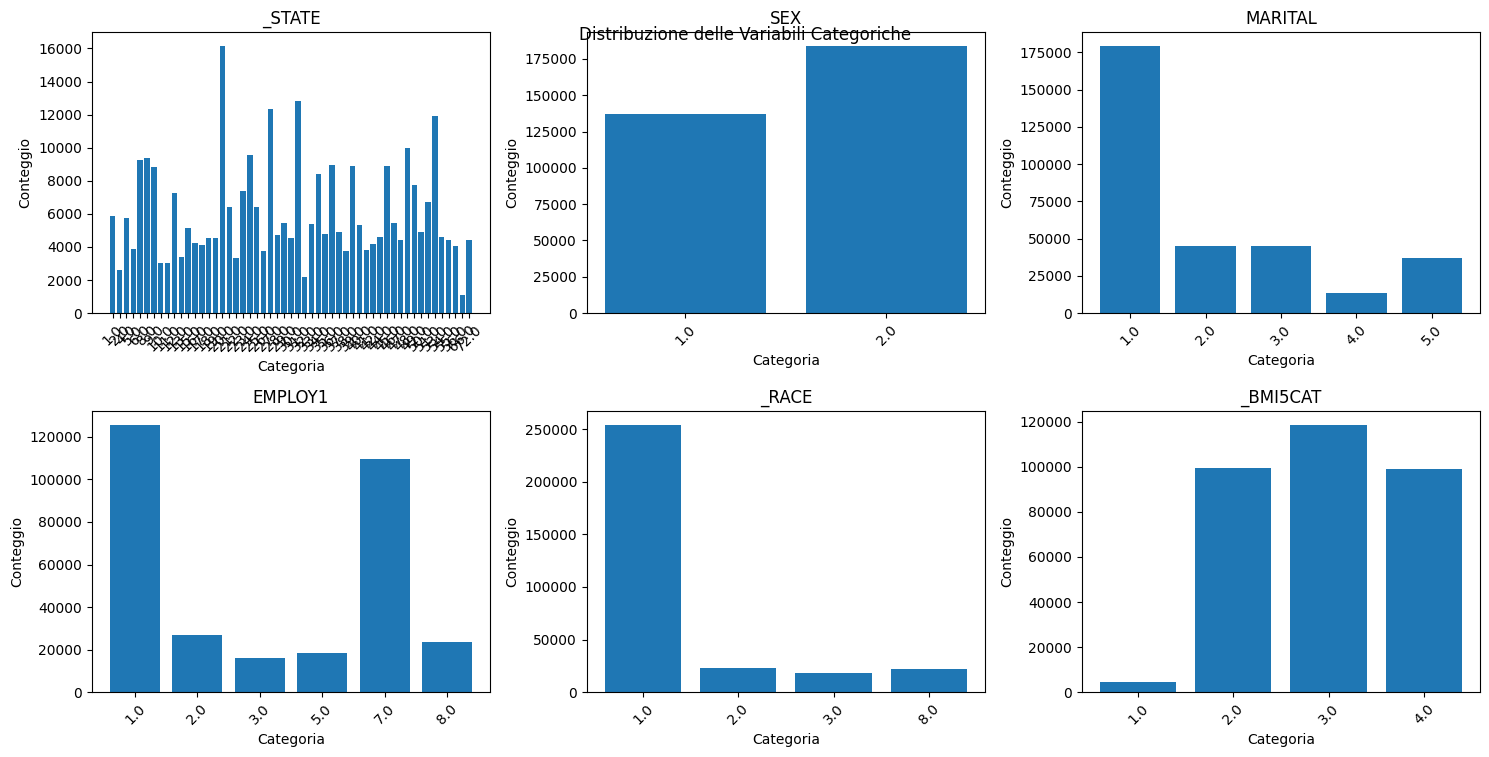

In [213]:
n = len(nominal_cols)
cols = 3
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
axes = axes.flatten()

for ax, col in zip(axes, nominal_cols):
    counts = df[col].value_counts().sort_index()
    ax.bar(counts.index.astype(str), counts.values)
    ax.set_title(col)
    ax.set_xlabel('Categoria')
    ax.set_ylabel('Conteggio')
    ax.tick_params(axis='x', rotation=45)

# Disattiva i subplot rimasti vuoti
for ax in axes[n:]:
    ax.axis('off')

fig.suptitle('Distribuzione delle Variabili Categoriche', y=0.92)
plt.tight_layout()
plt.show()

Effettuo il chi square test per verificare che tutte le variabili categoriche siano necessarie o meno.

In [214]:

state_map = {
    1: "Alabama", 2: "Alaska", 4: "Arizona", 5: "Arkansas", 6: "California",
    8: "Colorado", 9: "Connecticut", 10: "Delaware", 11: "District of Columbia",
    12: "Florida", 13: "Georgia", 15: "Hawaii", 16: "Idaho", 17: "Illinois",
    18: "Indiana", 19: "Iowa", 20: "Kansas", 21: "Kentucky", 22: "Louisiana",
    23: "Maine", 24: "Maryland", 25: "Massachusetts", 26: "Michigan",
    27: "Minnesota", 28: "Mississippi", 29: "Missouri", 30: "Montana",
    31: "Nebraska", 32: "Nevada", 33: "New Hampshire", 34: "New Jersey",
    35: "New Mexico", 36: "New York", 37: "North Carolina", 38: "North Dakota",
    39: "Ohio", 40: "Oklahoma", 41: "Oregon", 42: "Pennsylvania",
    44: "Rhode Island", 45: "South Carolina", 46: "South Dakota",
    47: "Tennessee", 48: "Texas", 49: "Utah", 50: "Vermont", 51: "Virginia",
    53: "Washington", 54: "West Virginia", 55: "Wisconsin", 56: "Wyoming",
    66: "Guam", 72: "Puerto Rico"
}
df['_STATE'] = df['_STATE'].map(state_map)

# Mappa stato -> regione
region_map = {
    'Maine':'Northeast','New Hampshire':'Northeast','Vermont':'Northeast',
    'Massachusetts':'Northeast','Rhode Island':'Northeast','Connecticut':'Northeast',
    'New York':'Northeast','New Jersey':'Northeast','Pennsylvania':'Northeast',
    'Ohio':'Midwest','Michigan':'Midwest','Indiana':'Midwest','Wisconsin':'Midwest',
    'Illinois':'Midwest','Minnesota':'Midwest','Iowa':'Midwest','Missouri':'Midwest',
    'North Dakota':'Midwest','South Dakota':'Midwest','Nebraska':'Midwest','Kansas':'Midwest',
    'Delaware':'South','Maryland':'South','District of Columbia':'South','Virginia':'South',
    'West Virginia':'South','North Carolina':'South','South Carolina':'South','Georgia':'South',
    'Florida':'South','Kentucky':'South','Tennessee':'South','Mississippi':'South',
    'Alabama':'South','Oklahoma':'South','Texas':'South','Arkansas':'South','Louisiana':'South',
    'Arizona':'West','Colorado':'West','Idaho':'West','Montana':'West','Nevada':'West',
    'New Mexico':'West','Utah':'West','Wyoming':'West','Alaska':'West','California':'West',
    'Hawaii':'West','Oregon':'West','Washington':'West','Guam':'West','Puerto Rico':'South'
}
df['_STATE'] = df['_STATE'].map(region_map).astype('category')

cat_cols = df.select_dtypes(include=['category']).columns.tolist()

# Considera solo variabili categoriche reali: numero di livelli ragionevole
categoricals = []
for c in cat_cols:
    nunq = df[c].nunique(dropna=True)
    if c != target and 2 <= nunq <= 20:
        categoricals.append(c)

results = []

for col in categoricals:
    # Costruisci la tabella di contingenza
    table = pd.crosstab(df[col], df[target])
    if table.shape[0] < 2 or table.shape[1] < 2:
        continue  # niente test se ha meno di 2 righe o colonne
    # Esegui Chi-quadrato
    chi2, p, dof, expected = chi2_contingency(table)
    # Calcola Phi o Cramér's V
    n = table.values.sum()
    phi2 = chi2 / n
    r, k = table.shape
    cramers_v = np.sqrt(phi2 / (min(r, k) - 1))
    # Conserva risultato
    results.append({
        'variable': col,
        'levels': table.shape,
        'chi2': chi2,
        'p_value': p,
        'cramers_v': cramers_v
    })

# Organizza in DataFrame e ordina per Cramér’s V decrescente
res_df = pd.DataFrame(results)
res_df = res_df.sort_values('cramers_v', ascending=False).reset_index(drop=True)

print(res_df[['variable','levels','chi2','p_value','cramers_v']])


    variable  levels          chi2        p_value  cramers_v
0    GENHLTH  (5, 3)  29977.144261   0.000000e+00   0.216185
1   _BMI5CAT  (4, 3)  16162.472862   0.000000e+00   0.158554
2    EMPLOY1  (6, 3)  14548.902395   0.000000e+00   0.150764
3     _AGE_G  (6, 3)  11044.127047   0.000000e+00   0.131066
4    INCOME2  (8, 3)   8808.412616   0.000000e+00   0.126243
5    CHOLCHK  (4, 3)   8614.474376   0.000000e+00   0.116516
6      EDUCA  (6, 3)   6370.552121   0.000000e+00   0.099636
7    _PACAT1  (4, 3)   4923.369536   0.000000e+00   0.089288
8   CHECKUP1  (5, 3)   4201.232226   0.000000e+00   0.081228
9      _RACE  (4, 3)   2657.462550   0.000000e+00   0.064705
10   MARITAL  (5, 3)   2547.654609   0.000000e+00   0.063066
11  _SMOKER3  (4, 3)   1451.570520  1.649110e-310   0.047677
12    _STATE  (4, 3)   1284.724796  2.195015e-274   0.044702
13  SEATBELT  (5, 3)    573.056699  1.446190e-118   0.029950
14       SEX  (2, 3)    274.013739   3.152627e-60   0.029196
15   USENOW3  (3, 3)    

elimino le ultime tre colonne

In [215]:
df.drop(columns=['SEATBELT', 'SEX', 'USENOW3'], inplace=True)

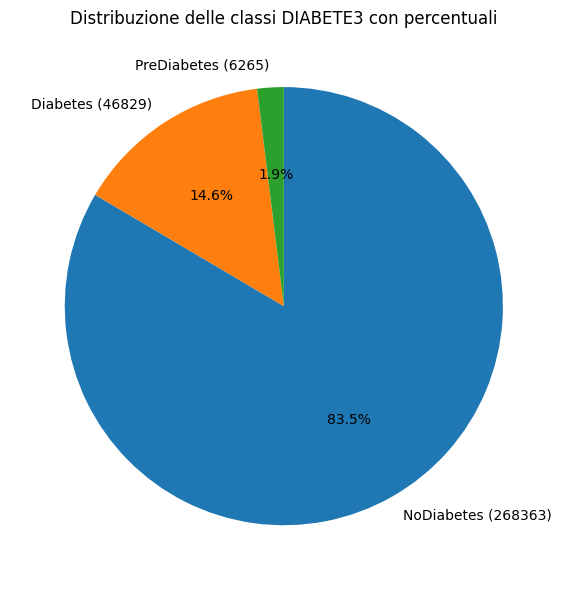

In [216]:
# Conta e calcola percentuali
counts = df['DIABETE3'].value_counts()
percents = counts / counts.sum() * 100

# Grafico a torta
plt.figure(figsize=(6, 6))
plt.pie(percents, labels=[f"{label} ({count})" for label, count in zip(counts.index, counts.values)],
        autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('Distribuzione delle classi DIABETE3 con percentuali')
plt.tight_layout()
plt.show()

Le classi sono moolto sbilanciate

In [217]:
df.to_csv('data.csv', index=False)

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321457 entries, 0 to 321456
Data columns (total 52 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   _STATE          321457 non-null  category
 1   GENHLTH         320707 non-null  category
 2   PHYSHLTH        315181 non-null  float64 
 3   MENTHLTH        316891 non-null  float64 
 4   HLTHPLN1        304968 non-null  Int64   
 5   PERSDOC2        287776 non-null  Int64   
 6   MEDCOST         27015 non-null   Int64   
 7   CHECKUP1        318370 non-null  category
 8   BPHIGH4         148310 non-null  Int64   
 9   BLOODCHO        321457 non-null  Int64   
 10  CHOLCHK         317268 non-null  category
 11  TOLDHI2         137499 non-null  Int64   
 12  CVDINFR4        21101 non-null   Int64   
 13  CVDCRHD4        21460 non-null   Int64   
 14  CVDSTRK3        14649 non-null   Int64   
 15  ASTHMA3         43177 non-null   Int64   
 16  CHCSCNCR        35369 non-null   Int64